# Blackout gap detection example notebook
This notebook shows
1. the usage of a blackout gap detection on a dataset of 500 CMLs and a 10 day period
2. two example CMLs with which have a very high and a very low number of blackout gaps

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pycomlink as pycml
import xarray as xr
from tqdm import tqdm
import urllib.request
import io
import pycomlink.processing.blackout_gap_detection as blackout_detection

# Do show xarray.Dataset representation as text because gitlab/github
# do not (yet) render the html output correctly (or sometimes not at all...)
xr.set_options(display_style="text");

In [2]:
# get data from 500 CMLs and eleven days
data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + "/example_cml_data.nc")

In [3]:
# get recieved signal levels values without default fill values (-99 and -99.9)
rsl = cmls.rsl.where(cmls.rsl > -99).isel(channel_id=0)

In [4]:
gap_start_list = []
gap_end_list = []
gap_mask_list = []

for cml_id in tqdm(rsl.cml_id):
    # select individual RSL time series
    rsl_i = rsl.sel(cml_id=cml_id)

    # check whether RSL before and after gaps are below rsl_threshold
    # here we take -65 dBm as threshold as all CMLs have a median RSL > -60 dBm
    gap_start, gap_end = blackout_detection.get_blackout_start_and_end(
        rsl=rsl_i.values, rsl_threshold=-65
    )
    
    # create a mask for all gaps fullflilling the criteria above
    mask = blackout_detection.created_blackout_gap_mask_from_start_end_markers(
        rsl_i.values, gap_start, gap_end
    )
    mask_reverse = blackout_detection.created_blackout_gap_mask_from_start_end_markers(
        rsl_i.values[::-1], gap_end[::-1], gap_start[::-1]
    )
    mask = mask | mask_reverse[::-1]

    gap_start_list.append(gap_start)
    gap_end_list.append(gap_end)
    gap_mask_list.append(mask)

100%|██████████| 500/500 [00:01<00:00, 409.43it/s]


In [5]:
# parse gap starts, ends and the mask to one xarray dataset with the CML data
rsl = rsl.to_dataset()
rsl["gap_start"] = (["cml_id", "time"], gap_start_list)
rsl["gap_end_list"] = (["cml_id", "time"], gap_end_list)
rsl["mask"] = (["cml_id", "time"], gap_mask_list)

In [6]:
# get the CMLs with the many blackout minutes (here more than 35)
rsl_blackouts = rsl.isel(cml_id=(np.array(gap_mask_list).sum(axis=1) > 35))
rsl_blackouts

<xarray.Dataset>
Dimensions:           (time: 15840, cml_id: 3)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id            (cml_id) object 'MY0493_2_MY2121_3' ... 'MY2121_2_MY211...
    length            (cml_id) float64 16.19 8.559 15.24
    site_a_latitude   (cml_id) float64 56.99 57.06 57.13
    site_a_longitude  (cml_id) float64 3.215 3.312 3.282
    site_b_latitude   (cml_id) float64 57.13 57.13 57.12
    site_b_longitude  (cml_id) float64 3.282 3.282 3.489
    channel_id        <U9 'channel_1'
    frequency         (cml_id) float64 1.92e+10 2.309e+10 1.82e+10
    polarization      (cml_id) object 'V' 'V' 'V'
Data variables:
    rsl               (cml_id, time) float32 -48.9 -48.5 -48.9 ... -47.6 -47.9
    gap_start         (cml_id, time) bool False False False ... False False
    gap_end_list      (cml_id, time) bool False False False ... False False
    mask              (cml_id, time) bool False False False ... False False

### CMLs with more than 35 minutes of blackout within the 10-day example data

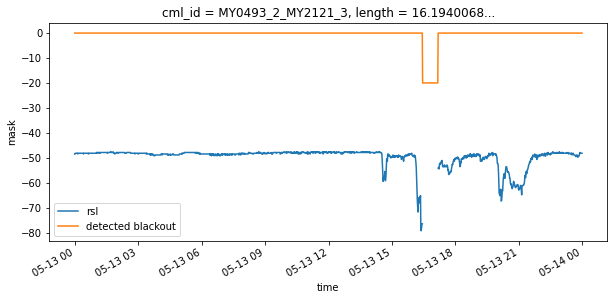

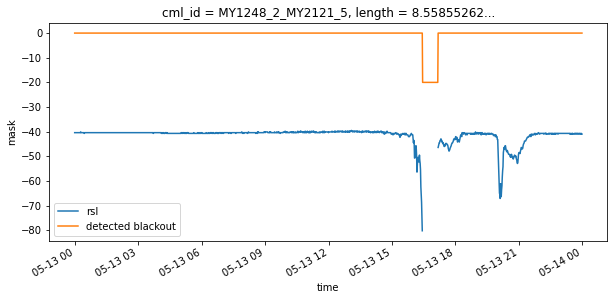

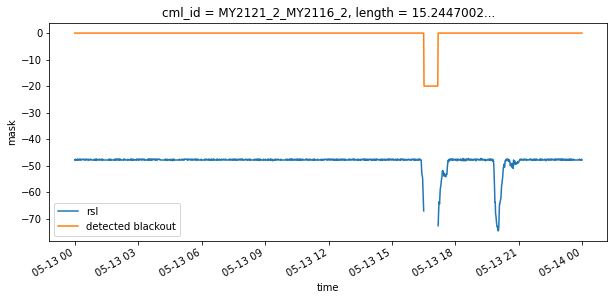

In [7]:
# plot the three CMLs with most blackouts minutes (more than 35 minutes)
for cml_id in rsl_blackouts.cml_id:
    rsl_blackouts.rsl.sel(cml_id=cml_id, time="2018-05-13").plot(
        figsize=(10, 4), label="rsl"
    )
    (rsl_blackouts.mask.sel(cml_id=cml_id, time="2018-05-13") * -20).plot(
        label="detected blackout"
    )
    plt.legend()

## Investiagte blackouts for two CMLs over three years
Data is available from  [this zenodo repository](https://zenodo.org/record/6337557) and has to be downloaded for the following analysis

In [8]:
# load data e.g. with. curl -0` or `wget` 
!curl -O https://zenodo.org/record/6337557/files/blackout_example_cmls.nc
!curl -O https://zenodo.org/record/6337557/files/blackout_example_radar_reference.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.7M  100 13.7M    0     0   624k      0  0:00:22  0:00:22 --:--:--  656k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.2M  100 12.2M    0     0   448k      0  0:00:27  0:00:27 --:--:-- 1269k


In [9]:
# open dataset with xarray
cmls = xr.open_dataset('blackout_example_cmls.nc')
reference = xr.open_dataset('blackout_example_radar_reference.nc')

The data consists of RSL and TSL from two CMLs with one minutes resolution over three years and respective path-averaged reference data from [RADKLIM-YW](https://opendata.dwd.de/climate_environment/CDC/help/landing_pages/doi_landingpage_RADKLIM_RW_V2017.002-de.html), a gauge-adjusted, climatologically correct weather radar product from the German Weather Service. 

In [10]:
cmls

<xarray.Dataset>
Dimensions:       (time: 1556689, cml_id: 2, channel_id: 2)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-01 ... 2021-01-01
  * cml_id        (cml_id) object 'DO2315_2_DO2314_2' 'NY1283_2_NY1294_3'
  * channel_id    (channel_id) object 'channel_1' 'channel_2'
Data variables:
    length        (cml_id) float64 ...
    tsl           (channel_id, cml_id, time) float32 ...
    rsl           (channel_id, cml_id, time) float32 ...
    frequency     (cml_id, channel_id) float64 ...
    polarization  (cml_id, channel_id) object ...

In [11]:
reference

<xarray.Dataset>
Dimensions:          (cml_id: 2, time: 1578236)
Coordinates:
  * cml_id           (cml_id) object 'DO2315_2_DO2314_2' 'NY1283_2_NY1294_3'
  * time             (time) datetime64[ns] 2018-01-01 ... 2020-12-31T23:55:00
Data variables:
    length           (cml_id) float64 ...
    rainfall_amount  (time, cml_id) float32 ...

In [12]:
# remove default rsl values
cmls["rsl"] = cmls.rsl.where(cmls.rsl > -99).isel(channel_id=0)
cmls["tsl"] = cmls.tsl.where(cmls.rsl > -99).isel(channel_id=0)

In [13]:
# define a plotting function
def plt_ts(rsl, tsl, ref, mask, start, ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    ay = ax.twinx()
    ay.bar(np.arange(len(ref)), ref * 60, color="#045a8d", alpha=0.6)
    ay.set_ylim(-10, 180)
    ay.set_yticks([0, 50, 100, 150])
    ay.set_ylabel("rainfall intensity \n[mm/h]", color="#045a8d")

    ax.plot(tsl, color="#238b45", label="transmitted \nsignal level", lw=2)
    ax.plot(rsl, color="#cc4c02", label="recieved \nsignal level", lw=2)

    ax.plot((mask * -5) + 33.5, lw=4, color="black")
    ax.plot((mask + 100), color="black", lw=3, label="detected \nblackout gap")

    ax.set_ylim(-92, 30)
    ax.set_title("")

    ax.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240])
    ax.set_xlabel("time [minutes]")
    ax.legend(
        loc="center left", ncol=3, 
    )

    ax.set_title(str(start.values)[0:10] + " " + str(start.values)[11:16])

    ax.set_yticks([20, 0, -20, -40, -60, -80])
    ax.set_ylabel("signal level\n[dBm]")
    plt.show()

For CML with the id DO2315_2_DO2314_2 there are 15 detected blackout minutes.
Plotting all detected gaps:


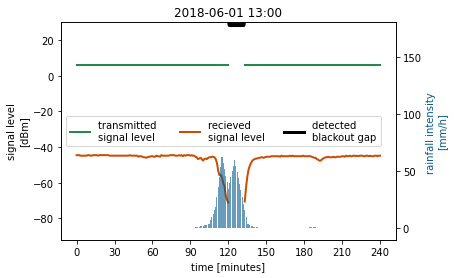

#################################################

For CML with the id NY1283_2_NY1294_3 there are 200 detected blackout minutes.
Plotting all detected gaps:


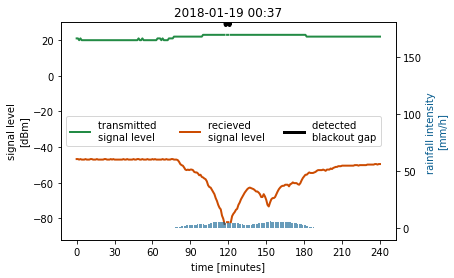

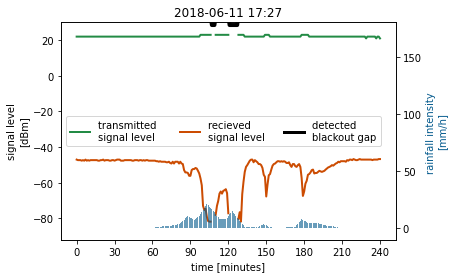

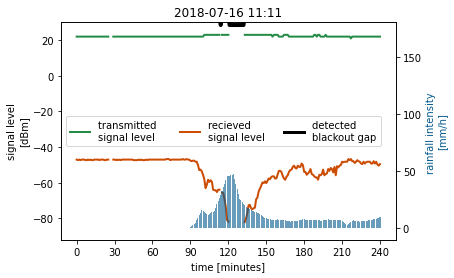

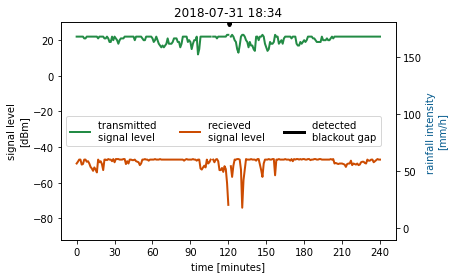

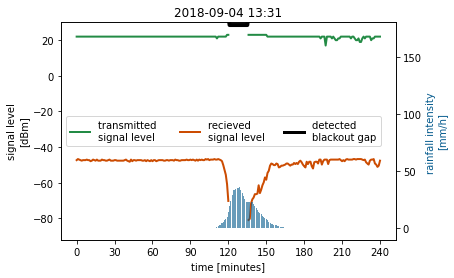

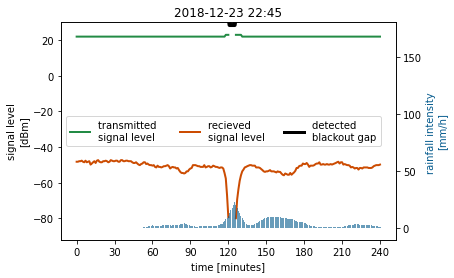

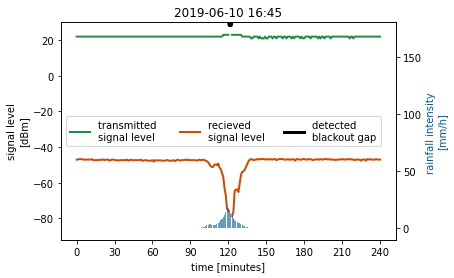

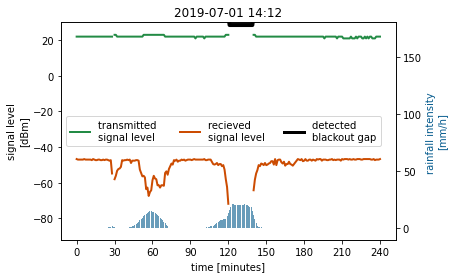

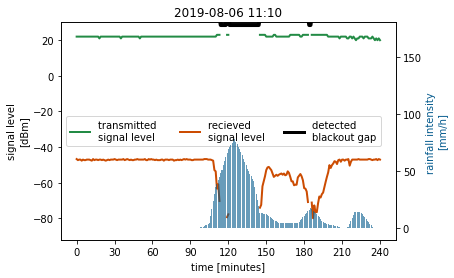

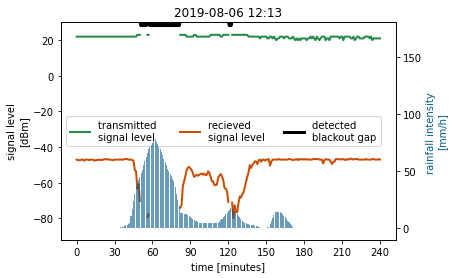

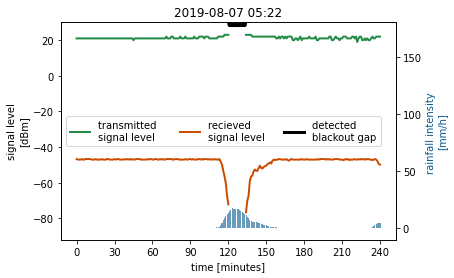

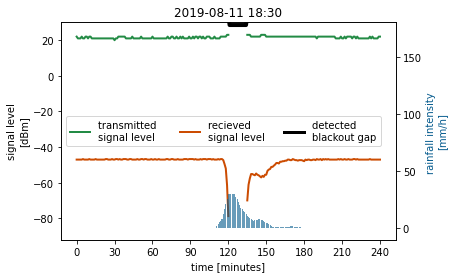

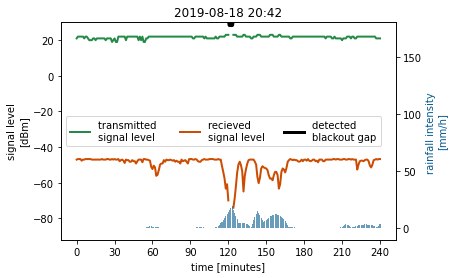

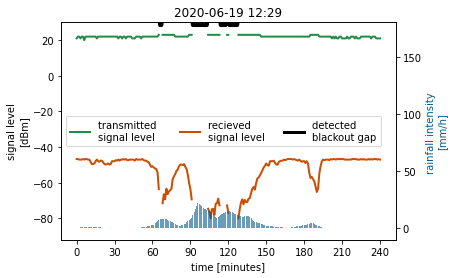

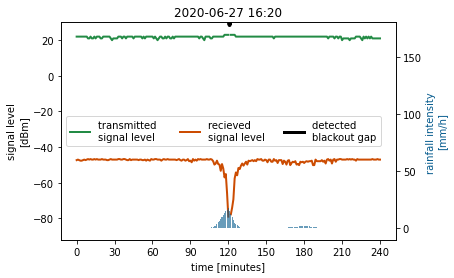

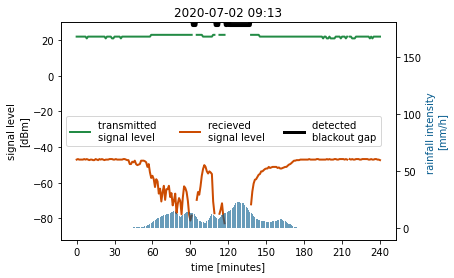

#################################################



In [14]:
for cml_id in cmls.cml_id:
    rsl = cmls.sel(cml_id=cml_id).rsl
    tsl = cmls.sel(cml_id=cml_id).tsl
    ref = reference.sel(cml_id=cml_id)
    
    # using the blackout gap detection as in the example above
    gap_start, gap_end = blackout_detection.get_blackout_start_and_end(
        rsl=rsl.values, rsl_threshold=-65
    )
    mask = blackout_detection.created_blackout_gap_mask_from_start_end_markers(
        rsl.values, gap_start, gap_end
    )
    mask_reverse = blackout_detection.created_blackout_gap_mask_from_start_end_markers(
        rsl.values[::-1], gap_end[::-1], gap_start[::-1]
    )
    mask = mask | mask_reverse[::-1]

    rsl = rsl.to_dataset()
    rsl["mask"] = ("time", mask)
    print(
        "For CML with the id "
        + str(cml_id.values)
        + " there are "
        + str(mask.sum())
        + " detected blackout minutes."
    )
    print("Plotting all detected gaps:")

    # remove gap_start times which are less than 60 minutes after another gap_start
    very_close_gaps = (
        np.diff(rsl.sel(time=gap_start).time.values) / 60000000000
    ).astype(int) < 60
    gap_time = rsl.sel(time=gap_start).time[~np.append(very_close_gaps, np.array(True))]

    # plot each gap
    for gap_start_time in gap_time:
        start = gap_start_time - np.timedelta64(2, "h")
        end = gap_start_time + np.timedelta64(2, "h")
        plt_ts(
            rsl=rsl.rsl.sel(time=slice(start, end)),
            tsl=tsl.sel(time=slice(start, end)),
            ref=ref.rainfall_amount.sel(time=slice(start, end)),
            mask=rsl.mask.sel(time=slice(start, end)),
            start=start,
        )
    print("#################################################\n")